# Use skorch to do random Hyperparameter search for 5G RNA-seq data (single-task)
Given data that has been transformed into log-ratio TPMs, search the hyperparameter spaces of various models
* Linear model
* Kmer count model
* CNN model
* CNN + LSTM model

## *** Log(TPM) 

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
from skorch import NeuralNetRegressor


## Load 5G logTPM data

In [4]:
locus_info_filename = 'data/locus2info.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

log_data_filename = "data/XY_logTPM_opFilt.tsv"
XY_log = pd.read_csv(log_data_filename,sep='\t')

display(XY_log.head())

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.701712,5.159314,4.946232,4.544309,5.470820,5.489315,5.580793,5.425377,6.017577,5.002269,5.148210,5.063677
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.906680,5.431592,5.067489,4.241518,5.897951,6.022614,6.305779,5.935676,6.629400,5.448133,5.385163,5.449226
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,5.085045,4.772192,4.208764,4.205855,4.821135,4.878684,5.067555,4.849435,5.487238,4.416274,4.367689,4.534353
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,5.604311,5.064503,4.983838,4.084119,5.639215,5.606737,5.604730,5.671486,6.282482,5.381454,5.098383,5.404872
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.766245,4.767261,3.688497,3.422344,4.763636,4.687598,4.858654,4.698693,4.286940,4.525268,5.031830,5.103249


In [5]:
loc2seq = dict([(x,z) for (x,z) in XY_log[['locus_tag','upstream_region']].values])

print(locus2info['EQU24_RS19315'])
print(loc2seq['EQU24_RS19315'])

{'gene': 'pmoC', 'product': 'methane monooxygenase/ammonia monooxygenase subunit C', 'type': 'CDS'}
ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAATGATCCGAAAAACAGGCTTTTGTAAGCAACCGATAAATAAGAGGTTAAGGGCTGGAAGATAAATGAAAATCAGGGTGGATAAAGAACTAATGATTAATAGCGCACTAGATCGGTCATAAATTAAGTTGACAAGCCTTTTCGAAATGATAAACTGAGCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA


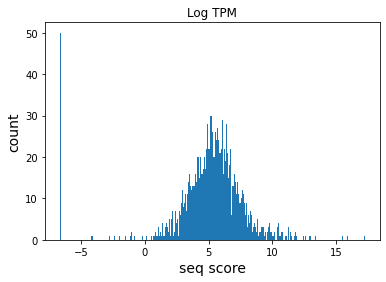

In [6]:
# Log TPM - highCu column
plt.hist(XY_log['highCu'].values,bins=500)
plt.title("score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.title("Log TPM")
plt.show()

In [7]:
for df in [XY_log]:
    df['gene'] = df['locus_tag'].apply(lambda x: locus2info[x]['gene'])
    df['product'] = df['locus_tag'].apply(lambda x: locus2info[x]['product'])


In [8]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,title,val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=['locus_tag','set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()

## Load 5G seqs into data loaders

In [12]:
# LOG
log_full_train_df,log_test_df = tu.quick_split(XY_log)
log_train_df, log_val_df = tu.quick_split(log_full_train_df)

print(log_full_train_df.shape)
print(log_test_df.shape)
print(log_train_df.shape)
print(log_val_df.shape)

assert(log_train_df.shape[0] + log_val_df.shape[0] == log_full_train_df.shape[0])

(1763, 18)
(441, 18)
(1410, 19)
(353, 19)


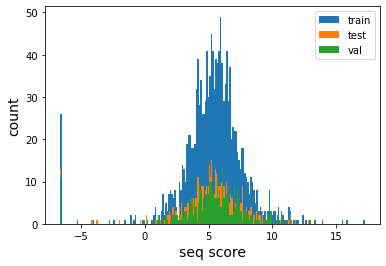

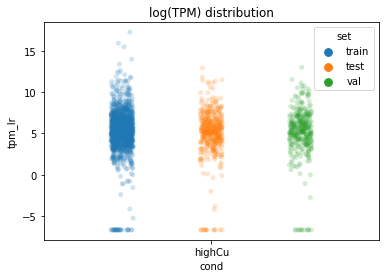

In [10]:
# plot_train_test_hist(log_full_train_df, log_test_df,score_col='highCu',bins=200)
# plot_train_test_hist(log_train_df, log_val_df,score_col='highCu',bins=200)

# split the genes, show dist of logTPM of HighCu column
plot_train_test_hist(log_train_df, log_test_df, val_df=log_val_df,score_col='highCu',bins=200)
view_train_test_dist(log_train_df, log_test_df,["highCu"],"log(TPM)",val_df=log_val_df)

In [11]:
dataset_types = [
    DatasetSpec('ohe'),
    DatasetSpec('kmer',k=3),
    DatasetSpec('kmer',k=6),
]

In [12]:
# Dfs for the full train/test split
log_final_dls = tu.build_dataloaders_single(
    log_full_train_df, 
    log_test_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu')

# Dfs from further spliting train into train and val
log_dls = tu.build_dataloaders_single(
    log_train_df, 
    log_val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu'
)

log_kmer6_train_dl,log_kmer6_val_dl = log_dls['kmer_6']
log_kmer3_train_dl,log_kmer3_val_dl = log_dls['kmer_3']
log_ohe_train_dl,log_ohe_val_dl = log_dls['ohe']

In [13]:
len(log_kmer6_train_dl.dataset.kmers)

4096

In [14]:
log_ohe_train_dl

## define basic single task models

In [9]:
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=5,
                 num_fc_nodes1=100,
                 num_fc_nodes2=10
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            #nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, num_fc_nodes1),
            nn.Linear(num_fc_nodes1, num_fc_nodes2),
            #nn.ReLU(inplace=True),
            nn.Linear(num_fc_nodes2, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

## training loop defs

In [68]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
    loss = loss_func(xb_out, yb.float())

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)

def train_step(model, train_dl, loss_func, opt):
    '''
    Execute 1 set of batch training for an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    # collect train loss; provide opt so backpropo happens
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(DEVICE),yb.to(DEVICE)

        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        tl.append(t)
        ns.append(n)
        
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    return train_loss

def val_step(model, val_dl, loss_func):
    '''
    Execute 1 set of batch validation for an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(DEVICE),yb.to(DEVICE)

            v, n = loss_batch(model, loss_func, xb, yb)
            vl.append(v)
            ns.append(n)

    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        train_loss = train_step(model, train_dl, loss_func, opt)
        train_losses.append(train_loss)
        
        
        val_loss = val_step(model, val_dl, loss_func)
        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

def run_model(train_dl,test_dl, model, lr=0.01, epochs=20):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    loss_func = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, test_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    #return model, train_losses, test_losses
    return train_losses, test_losses

def quick_loss_plot_simple(data_label_list,loss_type="MSE Loss",sparse_n=0):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,((train_data,test_data),label) in enumerate(data_label_list):
        # plot only 1 in every sparse_n points
        if sparse_n:
            train_data = [x for i,x in enumerate(train_data) if (i%sparse_n==0)]
            test_data = [x for i,x in enumerate(test_data) if (i%sparse_n==0)]
            
        plt.plot(train_data,'--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,'o-',color=f"C{i}", label=f"{label} Test",linewidth=3.0)
        

    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

In [19]:
seq_len = len(log_train_df['upstream_region'].values[0])
model_cnn = DNA_CNN(
    seq_len,
    num_filters=32, #128,
    kernel_size=8,
    num_fc_nodes1=10
)
model_cnn.to(DEVICE)

train_losses_cnn, \
test_losses_cnn = run_model(
    log_ohe_train_dl, 
    log_ohe_val_dl, 
    model_cnn, 
    lr=0.001,#0.0001,
    epochs=100,
)

# to plot loss
cnn_data_label = [((train_losses_cnn,test_losses_cnn),'CNN(my fit)')]


0 9.104557864051365
1 9.011812029074001
2 13.826429115814122
3 9.070981602493157
4 8.880463393484229
5 9.039608525824613
6 8.848032739277265
7 8.851123204650014
8 10.96526070019341
9 9.012467541032743
10 13.072842095458812
11 9.389836965134055
12 8.944754516774466
13 9.198848263737839
14 8.924246663750063
15 8.565686913455174
16 9.355790913611566
17 8.721042306159779
18 8.753954079603677
19 8.427444474217575
20 9.01418194081898
21 9.438266975683801
22 8.35014983952552
23 8.821655111339883
24 9.96926881233626
25 8.777106852436876
26 8.227003281244812
27 9.160218317177748
28 18.360298275609868
29 8.265557183760084
30 8.231529788322558
31 17.807117878208754
32 9.628377371401692
33 8.811254571585074
34 9.18423884178356
35 8.478726062828692
36 10.196215064937602
37 8.091121781649063
38 8.100925599549377
39 9.435746889951885
40 8.09484626078403
41 8.264138186619572
42 9.13292158359171
43 19.2904713444264
44 8.056444019501338
45 8.338542053449594
46 8.582135889415362
47 8.350151369997192
48 8

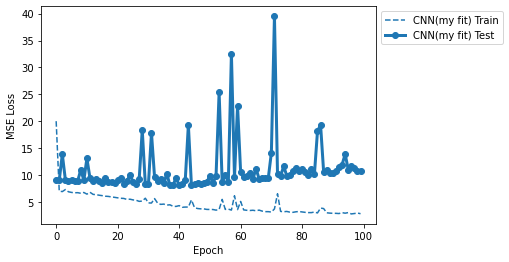

In [20]:
# basic CNN
quick_loss_plot_simple(cnn_data_label)

## try fitting with skorch instead

In [10]:
def make_skorch_dfs(df,seq_col='seq',target_col='score'):
    '''
    Make basic X,y matrix,vec for skorch fit() loop.
    '''
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
    # had to unsqueeze here or else errors later
    
    return ohe_seqs.float(), labels.float()

In [13]:
X, y = make_skorch_dfs(log_full_train_df, seq_col='upstream_region',target_col='highCu')
print("X:",X.shape)
print("y:",y.shape)

X: torch.Size([1763, 300, 4])
y: torch.Size([1763, 1])


In [77]:
from skorch.callbacks import EarlyStopping,Checkpoint,LoadInitState

In [43]:
# Make a skorch regressor object
net_regr = NeuralNetRegressor(
    DNA_CNN, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    max_epochs=100,
    lr=0.001, # this is passed to the skorch fit, i think
    device='cuda',  # uncomment this to train with CUDA
    callbacks=[EarlyStopping(patience=25),Checkpoint(dirname='testcheck')]
)

In [44]:
# Just call fit!
net_regr.fit(X, y)


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1       16.2015        8.7483     +  0.0442
      2        7.4753        8.8425        0.0441
      3        7.4344        8.7626        0.0443
      4        7.3799        8.6475     +  0.1983
      5        7.3212        8.4994     +  0.0462
      6        7.2580        8.3232     +  0.0455
      7        7.1900        8.1262     +  0.0460
      8        7.1176        7.9186     +  0.0469
      9        7.0416        7.7126     +  0.0449
     10        6.9632        7.5203     +  0.0463
     11        6.8836        7.3518     +  0.0459
     12        6.8039        7.2128     +  0.0455
     13        6.7247        7.1038     +  0.0466
     14        6.6463        7.0213     +  0.0457
     15        6.5682        6.9596     +  0.0464
     16        6.4901        6.9124     +  0.0472
     17        6.4114        6.8743     +  0.0452
     18        6.3316        6.8414     +  0.0455


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 31, kernel_size=(4, 5), stride=(1, 1))
      (1): Flatten()
      (2): Linear(in_features=9176, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=10, bias=True)
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)

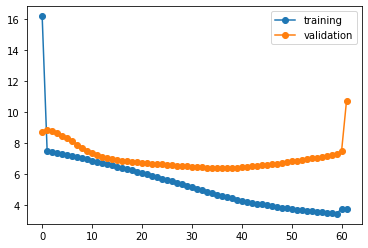

In [46]:
# plot net_regr's loss trace
train_loss = net_regr.history[:, 'train_loss']
valid_loss = net_regr.history[:, 'valid_loss']

plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
plt.legend()
plt.show()

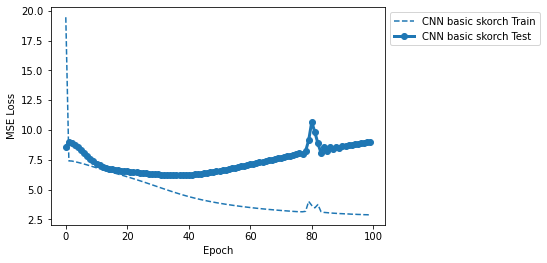

In [31]:
skorch_label = [((net_regr.history[:, 'train_loss'], net_regr.history[:, 'valid_loss']), 'CNN basic skorch')]
quick_loss_plot_simple(skorch_label)

In [29]:
#y_pred = net_regr.predict(X[:5])
y_pred = net_regr.predict(X)
y_pred = torch.tensor(y_pred).to(DEVICE)

net_regr.get_loss(y_pred, y)


tensor(4.0459, device='cuda:0')

## now try random search with some params

In [165]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform,uniform
from random import randint


In [166]:
net_search = NeuralNetRegressor(
    DNA_CNN,
    module__seq_len=300,
    max_epochs=100,
    #lr=0.001,
    device='cuda',  # uncomment this to train with CUDA
    callbacks=[
        EarlyStopping(patience=25),
        Checkpoint(dirname='testcheck_search',f_pickle='model.pkl')]

)

In [167]:
params = {
    'lr': [0.001, 0.0001,0.00001],#loguniform(0.0001, 0.01)
    
    'module__num_filters': [16,32,64,128], # uniform(8,128), #
    'module__kernel_size': [4,8,16,32],
    'module__num_fc_nodes1': [10, 25, 50,100], #randint(10,100), #
    'optimizer':[torch.optim.SGD, torch.optim.Adam, torch.optim.Adagrad,torch.optim.AdamW,torch.optim.RMSprop]
    #'optimizer__nesterov': [False, True],
}

In [173]:
search = RandomizedSearchCV(
    net_search, 
    params, 
    n_iter=10, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=3,#cv, 
    random_state=1,
    verbose=2
)

In [174]:
search.fit(X,y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1       20.5001       12.1226     +  0.0444
      2        8.8593        7.7914     +  0.0439
      3        7.7712        7.1144     +  0.0432


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.1s finished


      4        7.0550        7.0611     +  0.0438
      5        7.0852        7.0057     +  0.0439
      6        6.8806        6.8651     +  0.0442
      7        6.6989        6.7880     +  0.0434
      8        6.5779        6.7338     +  0.0435
      9        6.4366        6.6726     +  0.0438
     10        6.2821        6.6044     +  0.0433
     11        6.1256        6.5384     +  0.0435
     12        5.9686        6.4770     +  0.0434
     13        5.8096        6.4209     +  0.0432
     14        5.6456        6.3712     +  0.0436
     15        5.4737        6.3299     +  0.0430
     16        5.2930        6.3006     +  0.0430
     17        5.1060        6.2883     +  0.0437
     18        4.9173        6.2988        0.0433
     19        4.7319        6.3372        0.0435
     20        4.5542        6.4048        0.0433
     21        4.3878        6.4978        0.0434
     22        4.2364        6.6091        0.0431
     23        4.1020        6.7312        0.0437


RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.DNA_CNN'>,
  module__seq_len=300,
),
                   n_jobs=-1,
                   param_distributions={'lr': [0.001, 0.0001, 1e-05],
                                        'module__kernel_size': [4, 8, 16, 32],
                                        'module__num_fc_nodes1': [10, 25, 50,
                                                                  100],
                                        'module__num_filters': [16, 32, 64,
                                                                128],
                                        'optimizer': [<class 'torch.optim.sgd.SGD'>,
                                                      <class 'torch.optim.adam.Adam'>,
                                                      <class 'torch.optim.adagrad.Adagrad'>,
                                                      <class 'torch.optim.adamw.A

In [175]:
print(search.best_params_)
#print(search.best_estimator_)

{'optimizer': <class 'torch.optim.adam.Adam'>, 'module__num_filters': 16, 'module__num_fc_nodes1': 10, 'module__kernel_size': 32, 'lr': 0.001}


In [176]:
import pickle


In [177]:
thing = pickle.load(open("testcheck_search/model.pkl",'rb'))
print(thing.optimizer)
print(thing._kwargs)


<class 'torch.optim.adam.Adam'>
{'module__seq_len': 300, 'module__num_filters': 16, 'module__num_fc_nodes1': 10, 'module__kernel_size': 32}


In [63]:
thing.best_estimator_.predict(X)

array([[ 5.8633976],
       [ 5.2869716],
       [ 6.659303 ],
       ...,
       [ 5.5561056],
       [ 4.9248676],
       [10.518184 ]], dtype=float32)

In [64]:
search_label2 = [((search.best_estimator_.history[:, 'train_loss'], search.best_estimator_.history[:, 'valid_loss']), 'CNN search2')]

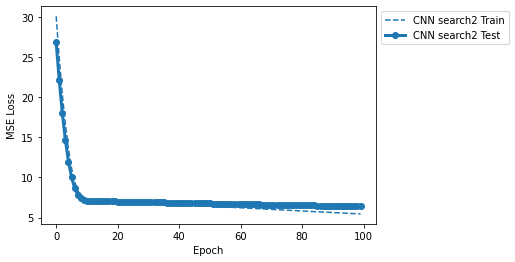

In [69]:
quick_loss_plot_simple(search_label2)

In [70]:
quick_loss_plot_simple(cnn_data_label+ skorch_label+search_label2)

NameError: name 'cnn_data_label' is not defined

In [71]:
# search history all losses?
search.best_estimator_.callbacks

## Compare some scores of the model combos tested

In [41]:
res_df = pd.DataFrame(search.cv_results_)
res_df['opt_name'] = res_df['param_optimizer'].apply(lambda x: x.__name__)
res_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__num_filters,param_module__num_fc_nodes1,param_module__kernel_size,param_lr,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,opt_name
0,8.672382,1.273625,0.008405,0.000380,<class 'torch.optim.adam.Adam'>,16,10,32,0.001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-16.179955,-17.348263,-17.114014,-17.671894,-20.874052,-17.837635,1.597393,79,Adam
1,6.532486,0.599377,0.009032,0.000312,<class 'torch.optim.adam.Adam'>,64,50,16,0.00001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-6.597996,-5.747299,-8.053168,-6.293436,-8.273332,-6.993046,0.996032,15,Adam
2,7.413659,0.130496,0.009733,0.000691,<class 'torch.optim.adam.Adam'>,128,25,8,0.0001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-13.050123,-14.679418,-13.992995,-14.277688,-15.210647,-14.242174,0.722974,66,Adam
3,6.375275,0.585531,0.008638,0.000714,<class 'torch.optim.adam.Adam'>,32,100,4,0.0001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-11.934196,-11.819713,-12.456670,-11.711022,-13.410325,-12.266385,0.626594,57,Adam
4,4.912613,0.897008,0.009204,0.001720,<class 'torch.optim.sgd.SGD'>,32,25,4,0.0001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-6.968347,-5.693146,-8.473737,-6.256790,-8.357043,-7.149812,1.110178,26,SGD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6.767984,0.375863,0.017209,0.012649,<class 'torch.optim.adagrad.Adagrad'>,128,25,8,0.001,{'optimizer': <class 'torch.optim.adagrad.Adag...,-10.501407,-10.481804,-10.642952,-11.798771,-13.074899,-11.299966,1.013701,53,Adagrad
96,4.690087,0.300074,0.008552,0.000081,<class 'torch.optim.sgd.SGD'>,16,10,4,0.00001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-9.152666,-23.795935,-14.424869,-9.805436,-12.968714,-14.029524,5.259107,65,SGD
97,5.611043,0.051608,0.008662,0.000532,<class 'torch.optim.adam.Adam'>,32,50,32,0.001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-19.122482,-22.754072,-18.900936,-20.724274,-23.525520,-21.005457,1.868799,87,Adam
98,4.664388,0.083527,0.008588,0.000184,<class 'torch.optim.sgd.SGD'>,16,100,4,0.00001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-23.160917,-10.017928,-14.869970,-6.681670,-14.361557,-13.818408,5.550855,64,SGD


In [42]:
sm_res_df = res_df[["rank_test_score","mean_test_score","param_module__num_filters","param_module__kernel_size","param_lr","param_module__num_fc_nodes1","opt_name"]]

In [43]:
alt.Chart(sm_res_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N"
    
).interactive()

alt.Chart(...)

In [44]:
alt.Chart(sm_res_df).mark_point().encode(
    x='param_module__num_filters:O',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
    column='opt_name:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N",
    tooltip=["param_module__num_filters:N","param_module__kernel_size:N","param_lr:N","param_module__num_fc_nodes1:N"]
    
).interactive()

alt.Chart(...)

## Check prediction distributions

In [52]:
Xval, yval = make_skorch_dfs(log_val_df, seq_col='upstream_region',target_col='highCu')
Xtest, ytest = make_skorch_dfs(log_test_df, seq_col='upstream_region',target_col='highCu')



In [53]:
# y pred and pearson on training data
ypred_train_basic = net_regr.predict(X)
ypred_train_search = search.best_estimator_.predict(X)
p_train_basic = scipy.stats.pearsonr(np.array(y).flatten(),ypred_train_basic.flatten())
p_train_search = scipy.stats.pearsonr(np.array(y).flatten(),ypred_train_search.flatten())

# y pred and pearson on val data
ypred_val_basic = net_regr.predict(Xval)
ypred_val_search = search.best_estimator_.predict(Xval)
p_val_basic = scipy.stats.pearsonr(np.array(yval).flatten(),ypred_val_basic.flatten())
p_val_search = scipy.stats.pearsonr(np.array(yval).flatten(),ypred_val_search.flatten())

# y pred and pearson on test data
ypred_test_basic = net_regr.predict(Xtest)
ypred_test_search = search.best_estimator_.predict(Xtest)
p_test_basic = scipy.stats.pearsonr(np.array(ytest).flatten(),ypred_test_basic.flatten())
p_test_search = scipy.stats.pearsonr(np.array(ytest).flatten(),ypred_test_search.flatten())



In [54]:
def ytrue_pred_hist(y,ypred,title):
    plt.hist(ypred,alpha=0.2, label="Y Pred")
    plt.hist(np.array(y),alpha=0.2, label="Y True")
    plt.legend()
    plt.title(title)
    plt.show()
    

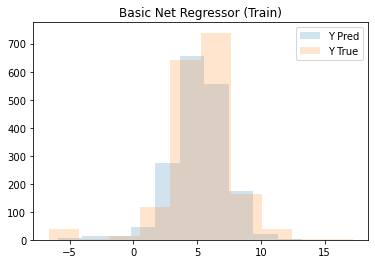

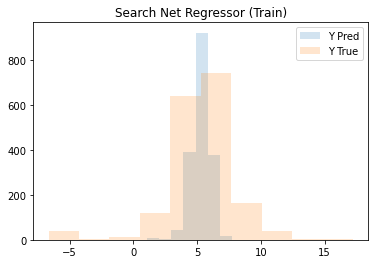

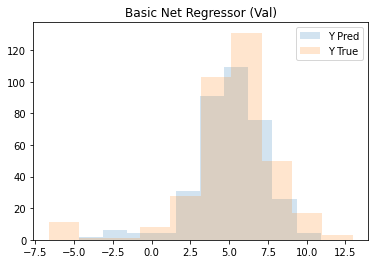

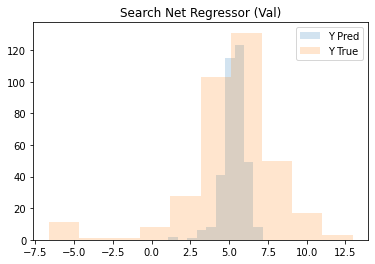

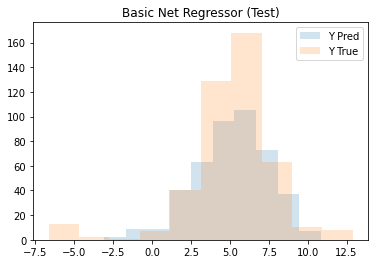

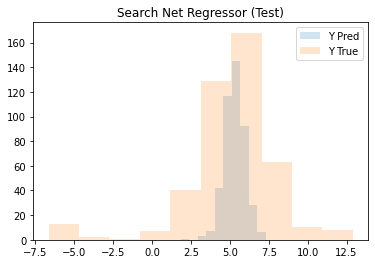

In [55]:
ytrue_pred_hist(y,ypred_train_basic,"Basic Net Regressor (Train)")
ytrue_pred_hist(y,ypred_train_search,"Search Net Regressor (Train)")

ytrue_pred_hist(yval,ypred_val_basic,"Basic Net Regressor (Val)")
ytrue_pred_hist(yval,ypred_val_search,"Search Net Regressor (Val)")

ytrue_pred_hist(ytest,ypred_test_basic,"Basic Net Regressor (Test)")
ytrue_pred_hist(ytest,ypred_test_search,"Search Net Regressor (Test)")

In [84]:
def parity_plot(model,ytrue,ypred, pearson,rigid=False):
    plt.scatter(ytrue, ypred, alpha=0.2)
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    if rigid:
        plt.ylim(min(xpoints),max(xpoints)) 
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.xlabel("Actual Score",fontsize=14)
    plt.ylabel("Predicted Score",fontsize=14)
    plt.title(f"{model} (pearson:{pearson:.3f})",fontsize=20)
    plt.show()

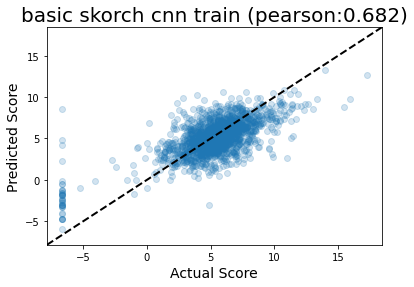

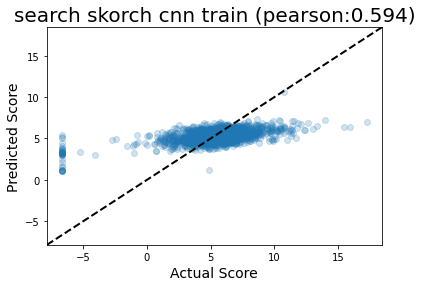

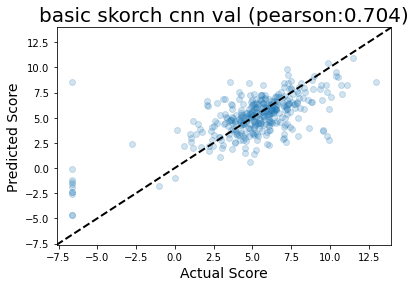

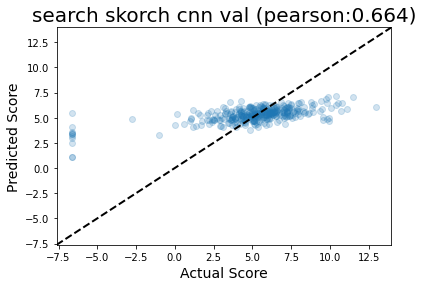

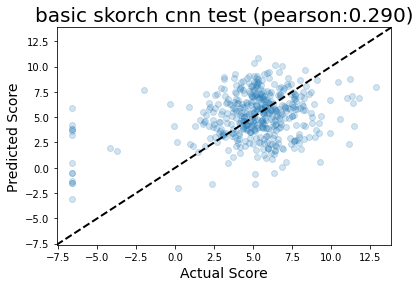

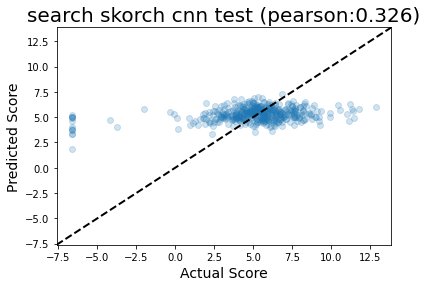

In [87]:
parity_plot("basic skorch cnn train", y, ypred_train_basic,p_train_basic[0],rigid=True)
parity_plot("search skorch cnn train", y, ypred_train_search,p_train_search[0],rigid=True)

parity_plot("basic skorch cnn val", yval, ypred_val_basic,p_val_basic[0],rigid=True)
parity_plot("search skorch cnn val", yval, ypred_val_search,p_val_search[0],rigid=True)

parity_plot("basic skorch cnn test", ytest, ypred_test_basic,p_test_basic[0],rigid=True)
parity_plot("search skorch cnn test", ytest, ypred_test_search,p_test_search[0],rigid=True)

In [51]:
b = search.best_estimator_
for i in b.module_.children():
    if type(i) == nn.Sequential:
        for child in i:
            if type(child) == nn.Conv2d:
                print(child.weight)

Parameter containing:
tensor([[[[ 3.4057e-02,  4.3642e-02, -1.9904e-01, -2.7334e-02],
          [-2.0415e-01, -1.3838e-01, -2.2525e-01,  1.6372e-01],
          [ 5.9070e-02,  1.4298e-01,  1.9506e-01, -2.2385e-01],
          [ 6.8632e-02, -2.0406e-01,  8.4021e-02, -2.0967e-01]]],


        [[[-1.1542e-01, -1.7631e-01, -6.6347e-02, -2.1405e-01],
          [ 9.5700e-02, -1.0333e-01,  1.9630e-01, -1.0735e-01],
          [-1.2648e-01,  1.3538e-01,  8.7525e-04,  1.5259e-01],
          [-1.8498e-01,  1.1219e-01,  6.2805e-02,  1.1183e-01]]],


        [[[ 1.8494e-01, -1.2967e-01, -1.4420e-01, -2.1125e-01],
          [ 1.0075e-02,  1.1691e-01, -1.2725e-03,  1.5102e-01],
          [ 1.5237e-01,  9.9624e-02, -6.9806e-02,  4.0394e-02],
          [ 2.1143e-01, -1.0865e-01, -1.8518e-01,  2.0652e-01]]],


        ...,


        [[[ 6.1595e-02, -1.4699e-01,  4.3739e-02,  2.3188e-01],
          [ 1.3863e-01, -3.9582e-02,  1.7993e-01, -8.9094e-02],
          [ 7.1283e-04, -5.9587e-02, -1.7954e-02, -2.26

In [58]:
b.score(Xtest,ytest)

0.09038980006140596

# Run skorch with a Pytorch data loader

In [202]:
net_dl = NeuralNetRegressor(
    DNA_CNN,
    module__seq_len=300,
    max_epochs=100,
    #lr=0.001,
    device='cuda',  # uncomment this to train with CUDA
    iterator_train = log_ohe_train_dl,
    iterator_valid = log_ohe_val_dl
)

In [203]:
search_dl = RandomizedSearchCV(
    net_dl, 
    params, 
    n_iter=200, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=3,#cv, 
    random_state=1,
    verbose=2
)

In [204]:
search_dl.fit(X, y)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 302 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   30.0s finished


TypeError: 'DataLoader' object is not callable

The FAQ seems to say to NOT provide a Dataset if possible - skorch does Dataloader stuff under the hood? 

"skorch supports datasets as input but sklearn doesn’t. If it’s possible, you should provide your data in a non-dataset format, e.g. as a numpy array or torch tensor, extracted from your original dataset."
https://skorch.readthedocs.io/en/stable/user/FAQ.html#faq-how-do-i-use-a-pytorch-dataset-with-skorch

# Run Skorch with MT model

In [59]:
condition_file = 'data/conditions_to_include.txt'
with open(condition_file,'r') as f:
    conditions = list(x.strip() for x in f.readlines())
    
cond_dict = dict(enumerate(conditions))
cond_dict

{0: 'uMax',
 1: 'lowO2_fast_growth',
 2: 'lowCH4',
 3: 'MeOH',
 4: 'NoCu',
 5: 'medCu',
 6: 'highCu',
 7: 'lowCu',
 8: 'highO2_slow_growth',
 9: 'NO3_lowO2_slow_growth',
 10: 'WithLanthanum',
 11: 'NoLanthanum'}

In [60]:
class DNA_CNN_Multi(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=5,
                 num_fc_nodes1=100,
                 num_fc_nodes2=10
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            #nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, num_fc_nodes1),
            nn.Linear(num_fc_nodes1, num_fc_nodes2),
        )
        # define the multi task objectives?
        self.obj0   = nn.Linear(num_fc_nodes2,1)
        self.obj1   = nn.Linear(num_fc_nodes2,1)
        self.obj2   = nn.Linear(num_fc_nodes2,1)
        self.obj3   = nn.Linear(num_fc_nodes2,1)
        self.obj4   = nn.Linear(num_fc_nodes2,1)
        self.obj5   = nn.Linear(num_fc_nodes2,1)
        self.obj6   = nn.Linear(num_fc_nodes2,1)
        self.obj7   = nn.Linear(num_fc_nodes2,1)
        self.obj8   = nn.Linear(num_fc_nodes2,1)
        self.obj9   = nn.Linear(num_fc_nodes2,1)
        self.obj10  = nn.Linear(num_fc_nodes2,1)
        self.obj11  = nn.Linear(num_fc_nodes2,1)
        

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        
        out = self.conv_net(xb)
        
        out0 = self.obj0(out).squeeze(1)
        out1 = self.obj1(out).squeeze(1)
        out2 = self.obj2(out).squeeze(1)
        out3 = self.obj3(out).squeeze(1)
        out4 = self.obj4(out).squeeze(1)
        out5 = self.obj5(out).squeeze(1)
        out6 = self.obj6(out).squeeze(1)
        out7 = self.obj7(out).squeeze(1)
        out8 = self.obj8(out).squeeze(1)
        out9 = self.obj9(out).squeeze(1)
        out10 = self.obj10(out).squeeze(1)
        out11 = self.obj11(out).squeeze(1)
        
        #print("out0", out0.shape)
        all_outs = torch.stack([out0,out1,out2,out3,out4,out5,out6,out7,out8,out9,out10,out11])
        #print("all_outs",all_outs.shape)
#         print("convert list to tensor?")
#         all_outs = torch.tensor(all_outs)
#         print(all_outs.shape)
        #print(all_outs)
#    shape fix here??
        #print("all_outs shape", all_outs.shape)
        #print("transpose?", all_outs.T.shape)
        
        #all_outs.squeeze(2)
        
        return all_outs.T

In [61]:
def make_multi_skorch_dfs(df,seq_col='seq',target_cols=conditions):
    ### EDIT THIS FOR MULTI TASK!
    
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    labels = torch.tensor(list(df[target_cols].values))
    # bad dimension? fixed in model.forward for now
    
    return ohe_seqs.float(), labels.float()

In [65]:
Xm,ym = make_multi_skorch_dfs(log_full_train_df, seq_col='upstream_region')
print("X:",X.shape)
print("y:",y.shape)

X: torch.Size([1763, 300, 4])
y: torch.Size([1763, 1])


In [66]:
mnet_regr = NeuralNetRegressor(
    DNA_CNN_Multi,
    module__seq_len=300,
    max_epochs=100,
    lr=0.0001,
    device='cuda',  # uncomment this to train with CUDA
)

In [67]:
mnet_regr.fit(Xm, ym)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       34.8529       33.7938  0.0651
      2       34.5523       33.5005  0.0627
      3       34.2513       33.2046  0.0628
      4       33.9460       32.9023  0.0620
      5       33.6326       32.5900  0.0629
      6       33.3075       32.2640  0.0620
      7       32.9666       31.9202  0.0617
      8       32.6058       31.5545  0.0624
      9       32.2207       31.1623  0.0621
     10       31.8064       30.7386  0.0621
     11       31.3577       30.2779  0.0625
     12       30.8685       29.7741  0.0629
     13       30.3325       29.2206  0.0622
     14       29.7425       28.6100  0.0634
     15       29.0908       27.9346  0.0634
     16       28.3692       27.1861  0.0627
     17       27.5692       26.3563  0.0619
     18       26.6822       25.4372  0.0620
     19       25.7005       24.4221  0.0629
     20       24.6180       23.3069  0.0622
     21       23.4316       22.0

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_CNN_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 31, kernel_size=(4, 5), stride=(1, 1))
      (1): Flatten()
      (2): Linear(in_features=9176, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=10, bias=True)
    )
    (obj0): Linear(in_features=10, out_features=1, bias=True)
    (obj1): Linear(in_features=10, out_features=1, bias=True)
    (obj2): Linear(in_features=10, out_features=1, bias=True)
    (obj3): Linear(in_features=10, out_features=1, bias=True)
    (obj4): Linear(in_features=10, out_features=1, bias=True)
    (obj5): Linear(in_features=10, out_features=1, bias=True)
    (obj6): Linear(in_features=10, out_features=1, bias=True)
    (obj7): Linear(in_features=10, out_features=1, bias=True)
    (obj8): Linear(in_features=10, out_features=1, bias=True)
    (obj9): Linear(in_features=10, out_features=1, bias=True)
    (obj10): Linear(in_features=10, out_features=1, 

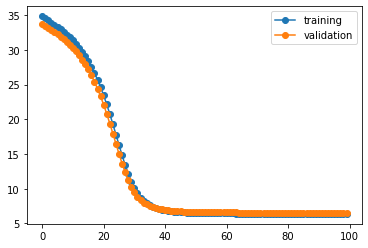

In [68]:
train_loss = mnet_regr.history[:, 'train_loss']
valid_loss = mnet_regr.history[:, 'valid_loss']

plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
plt.legend()
plt.show()

In [69]:
ympred_train = mnet_regr.predict(Xm)
ympred_train.shape

(1763, 12)

### Loop through each task and look at parity plot?

In [85]:
def check_mt_pred_results(y,ypred,title):
    '''
    Check individual task predictions within MT?
    '''
    for i in cond_dict:
        task=cond_dict[i]
        subtitle = f"{task} - {title}"
        print(f"task:{task}")
        yi = y[:,i]
        ypredi = ypred[:,i]

        pr = scipy.stats.pearsonr(np.array(yi).flatten(),ypredi.flatten())
        ytrue_pred_hist(yi,ypredi,subtitle)
        parity_plot(f"skorch cnn {task}", yi, ypredi,pr[0],rigid=True)

task:uMax


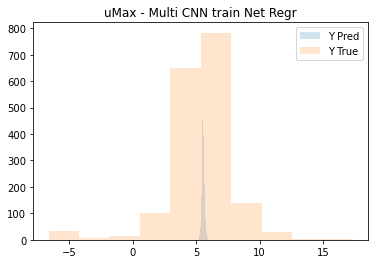

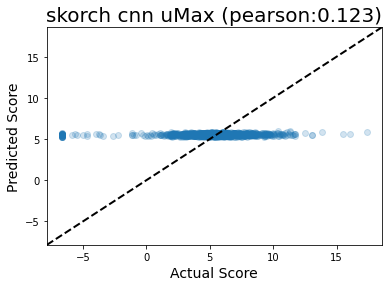

task:lowO2_fast_growth


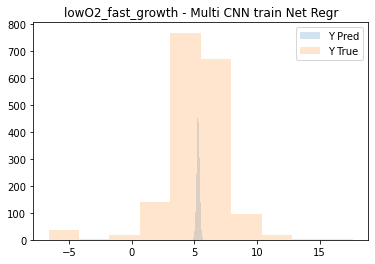

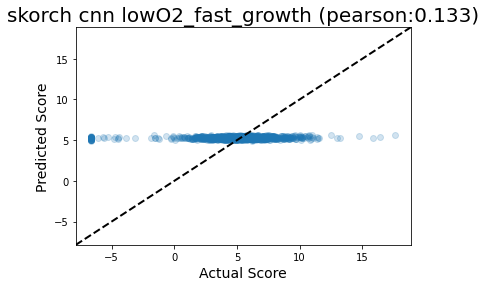

task:lowCH4


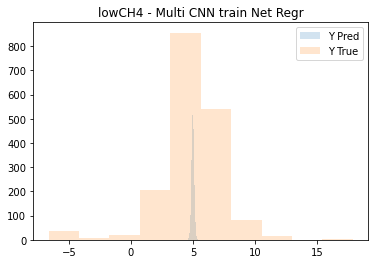

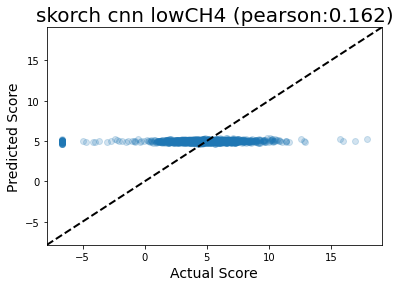

task:MeOH


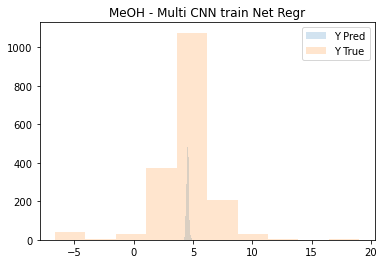

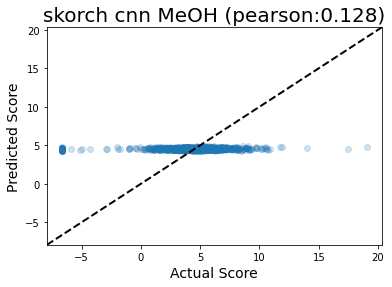

task:NoCu


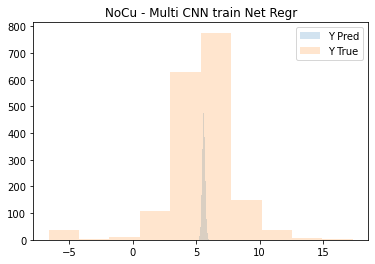

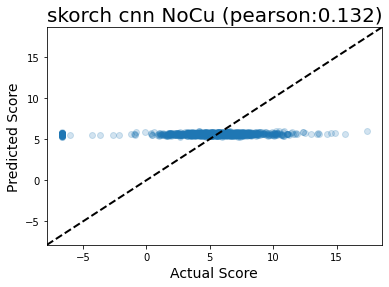

task:medCu


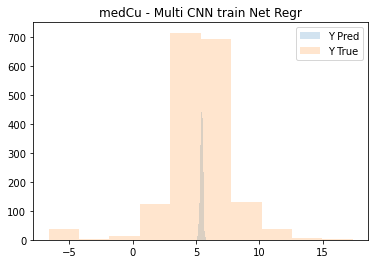

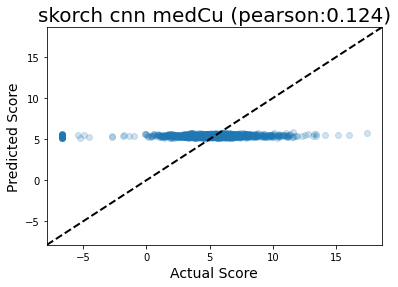

task:highCu


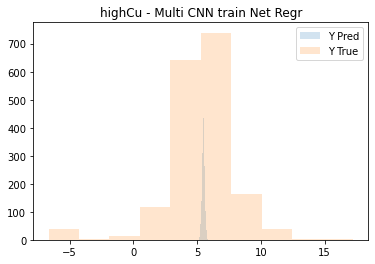

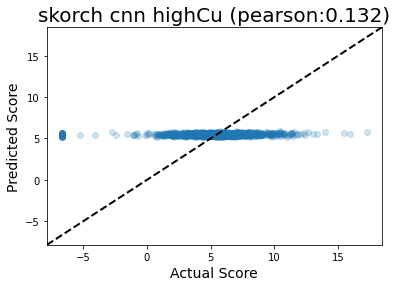

task:lowCu


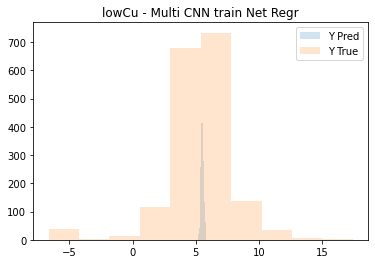

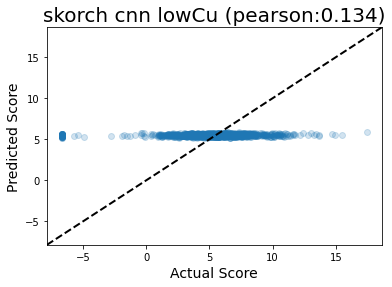

task:highO2_slow_growth


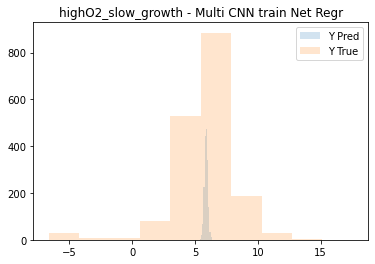

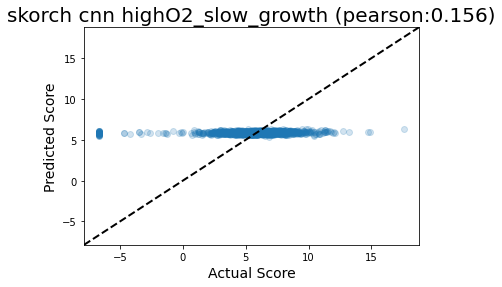

task:NO3_lowO2_slow_growth


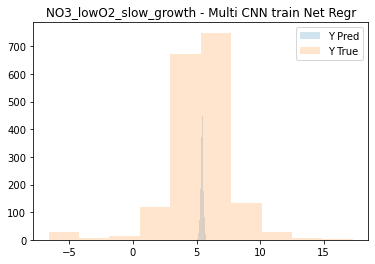

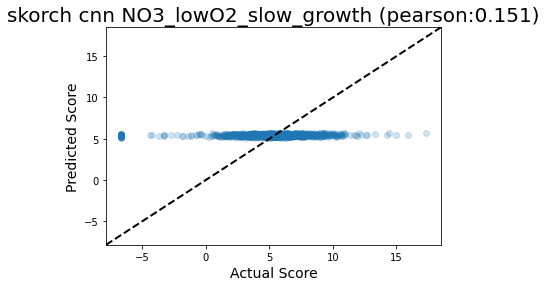

task:WithLanthanum


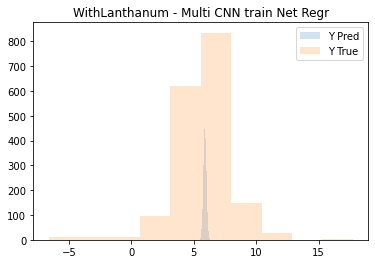

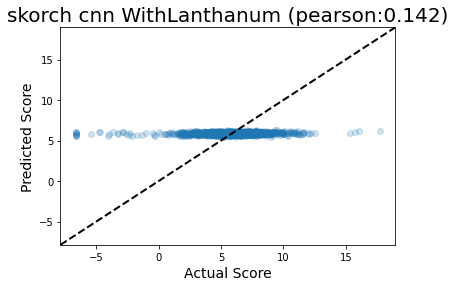

task:NoLanthanum


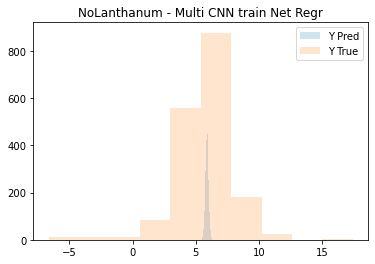

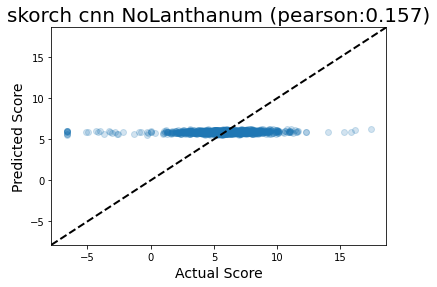

In [86]:
check_mt_pred_results(ym, ympred_train, "Multi CNN train Net Regr")

# skorch param search with MT

In [88]:
params = {
    'lr': [0.0005, 0.0001,0.00001],#loguniform(0.0001, 0.01)
    
    'module__num_filters': [16,32,64,128], # uniform(8,128), #
    'module__kernel_size': [4,8,16,32],
    'module__num_fc_nodes1': [10, 25, 50,100], #randint(10,100), #
    'optimizer':[torch.optim.SGD, torch.optim.Adam, torch.optim.Adagrad,torch.optim.AdamW,torch.optim.RMSprop]
    #'optimizer__nesterov': [False, True],
}

mnet_search = NeuralNetRegressor(
    DNA_CNN_Multi,
    module__seq_len=300,
    max_epochs=500,
    #lr=0.0001,
    device='cuda',  # uncomment this to train with CUDA
)

m_search = RandomizedSearchCV(
    mnet_search, 
    params, 
    n_iter=500, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=5,#cv, 
    random_state=1,
    verbose=2
)

In [89]:
m_search.fit(Xm, ym)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 86.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 147.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 227.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 328.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 448.6min


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       34.2929       32.3014  0.0699
      2       32.4298       30.6530  0.0684


[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 565.9min finished


      3       30.7913       29.1553  0.0686
      4       29.2710       27.7340  0.0655
      5       27.8080       26.3470  0.0656
      6       26.3686       24.9726  0.0654
      7       24.9369       23.6026  0.0643
      8       23.5092       22.2382  0.0644
      9       22.0897       20.8868  0.0639
     10       20.6881       19.5592  0.0632
     11       19.3170       18.2679  0.0637
     12       17.9898       17.0258  0.0634
     13       16.7197       15.8443  0.0626
     14       15.5183       14.7336  0.0627
     15       14.3952       13.7014  0.0635
     16       13.3575       12.7532  0.0629
     17       12.4099       11.8919  0.0630
     18       11.5542       11.1183  0.0627
     19       10.7899       10.4307  0.0634
     20       10.1143        9.8256  0.0631
     21        9.5229        9.2981  0.0626
     22        9.0098        8.8422  0.0625
     23        8.5684        8.4512  0.0622
     24        8.1914        8.1181  0.0623
     25        7.8716        7.8

    136        5.8347        6.1929  0.0617
    137        5.8298        6.1904  0.0616
    138        5.8250        6.1880  0.0615
    139        5.8201        6.1856  0.0620
    140        5.8153        6.1832  0.0617
    141        5.8104        6.1807  0.0618
    142        5.8055        6.1783  0.0617
    143        5.8007        6.1759  0.0618
    144        5.7958        6.1735  0.0622
    145        5.7909        6.1710  0.0622
    146        5.7860        6.1686  0.0627
    147        5.7811        6.1662  0.0623
    148        5.7762        6.1638  0.0619
    149        5.7713        6.1613  0.0619
    150        5.7664        6.1589  0.0622
    151        5.7615        6.1565  0.0628
    152        5.7565        6.1541  0.0626
    153        5.7516        6.1517  0.0620
    154        5.7467        6.1492  0.0620
    155        5.7417        6.1468  0.0622
    156        5.7368        6.1444  0.0620
    157        5.7318        6.1420  0.0620
    158        5.7269        6.1

    269        5.1448        5.8799  0.0618
    270        5.1393        5.8777  0.0618
    271        5.1338        5.8755  0.0624
    272        5.1283        5.8732  0.0617
    273        5.1227        5.8710  0.0619
    274        5.1172        5.8688  0.0618
    275        5.1117        5.8666  0.0616
    276        5.1061        5.8644  0.0617
    277        5.1005        5.8622  0.0617
    278        5.0950        5.8600  0.0619
    279        5.0894        5.8578  0.0620
    280        5.0839        5.8556  0.0626
    281        5.0783        5.8534  0.0620
    282        5.0727        5.8512  0.0622
    283        5.0671        5.8490  0.0623
    284        5.0616        5.8468  0.0617
    285        5.0560        5.8447  0.0618
    286        5.0504        5.8425  0.0617
    287        5.0448        5.8403  0.0619
    288        5.0392        5.8382  0.0623
    289        5.0336        5.8360  0.0620
    290        5.0280        5.8338  0.0619
    291        5.0224        5.8

    402        4.3896        5.6356  0.0624
    403        4.3840        5.6344  0.0625
    404        4.3784        5.6333  0.0623
    405        4.3728        5.6321  0.0621
    406        4.3672        5.6309  0.0621
    407        4.3616        5.6298  0.0624
    408        4.3560        5.6287  0.0627
    409        4.3505        5.6276  0.0625
    410        4.3449        5.6265  0.0626
    411        4.3393        5.6254  0.0625
    412        4.3338        5.6243  0.0626
    413        4.3282        5.6233  0.0625
    414        4.3227        5.6222  0.0632
    415        4.3172        5.6212  0.0634
    416        4.3117        5.6202  0.0637
    417        4.3061        5.6192  0.0636
    418        4.3006        5.6182  0.0642
    419        4.2951        5.6173  0.0633
    420        4.2897        5.6163  0.0630
    421        4.2842        5.6154  0.0633
    422        4.2787        5.6145  0.0628
    423        4.2732        5.6136  0.0627
    424        4.2678        5.6

RandomizedSearchCV(cv=5,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.DNA_CNN_Multi'>,
  module__seq_len=300,
),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'lr': [0.0005, 0.0001, 1e-05],
                                        'module__kernel_size': [4, 8, 16, 32],
                                        'module__num_fc_nodes1': [10, 25, 50,
                                                                  100],
                                        'module__num_filters': [16, 32, 64,
                                                                128],
                                        'optimizer': [<class 'torch.optim.sgd.SGD'>,
                                                      <class 'torch.optim.adam.Adam'>,
                                                      <class 'torch.optim.adagrad.Adagrad'>,
                                                      <class '

In [90]:
m_search.best_estimator_

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_CNN_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): Flatten()
      (2): Linear(in_features=38016, out_features=25, bias=True)
      (3): Linear(in_features=25, out_features=10, bias=True)
    )
    (obj0): Linear(in_features=10, out_features=1, bias=True)
    (obj1): Linear(in_features=10, out_features=1, bias=True)
    (obj2): Linear(in_features=10, out_features=1, bias=True)
    (obj3): Linear(in_features=10, out_features=1, bias=True)
    (obj4): Linear(in_features=10, out_features=1, bias=True)
    (obj5): Linear(in_features=10, out_features=1, bias=True)
    (obj6): Linear(in_features=10, out_features=1, bias=True)
    (obj7): Linear(in_features=10, out_features=1, bias=True)
    (obj8): Linear(in_features=10, out_features=1, bias=True)
    (obj9): Linear(in_features=10, out_features=1, bias=True)
    (obj10): Linear(in_features=10, out_features=1, 

In [91]:
m_search.best_params_

{'optimizer': torch.optim.sgd.SGD,
 'module__num_filters': 128,
 'module__num_fc_nodes1': 25,
 'module__kernel_size': 4,
 'lr': 0.0001}

In [92]:
mres_df = pd.DataFrame(m_search.cv_results_)
mres_df['opt_name'] = mres_df['param_optimizer'].apply(lambda x: x.__name__)
mres_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__num_filters,param_module__num_fc_nodes1,param_module__kernel_size,param_lr,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,opt_name
0,59.104487,0.685902,0.010845,0.001480,<class 'torch.optim.adam.Adam'>,16,10,32,0.0005,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-18.853952,-23.230394,-21.319815,-22.497879,-22.695402,-21.719489,1.562829,376,Adam
1,59.337368,2.253942,0.013646,0.002544,<class 'torch.optim.adam.Adam'>,64,50,16,0.00001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-5.946605,-5.320988,-7.279854,-5.753273,-8.405795,-6.541303,1.138913,123,Adam
2,62.643943,0.526686,0.014259,0.001357,<class 'torch.optim.adam.Adam'>,128,25,8,0.0001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-17.657255,-21.508598,-20.662313,-21.507624,-22.012827,-20.669724,1.567465,355,Adam
3,57.970003,2.599069,0.011775,0.001051,<class 'torch.optim.adam.Adam'>,32,100,4,0.0001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-18.295582,-19.663145,-19.988087,-18.631847,-20.820629,-19.479858,0.917735,340,Adam
4,40.366428,4.052095,0.012646,0.002078,<class 'torch.optim.sgd.SGD'>,32,25,4,0.0001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-6.104009,-4.963671,-7.213747,-5.209205,-7.599255,-6.217977,1.049131,47,SGD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,54.819225,1.421057,0.013606,0.001281,<class 'torch.optim.rmsprop.RMSprop'>,128,10,8,0.0005,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-19.959888,-24.360632,-22.448183,-22.932302,-22.832281,-22.506657,1.429257,413,RMSprop
496,56.441145,0.595706,0.011243,0.000335,<class 'torch.optim.adam.Adam'>,16,100,4,0.00001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-6.131781,-4.998219,-6.853837,-5.415829,-7.572523,-6.194438,0.935417,31,Adam
497,43.649200,5.467568,0.015853,0.005174,<class 'torch.optim.sgd.SGD'>,32,10,8,0.00001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-7.034853,-9.071085,-13.716123,-13.504837,-8.366921,-10.338764,2.751057,248,SGD
498,77.238276,5.039324,0.017579,0.003002,<class 'torch.optim.adam.Adam'>,128,100,16,0.0005,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-21.778761,-26.515709,-24.488634,-25.060144,-24.044800,-24.377610,1.543660,460,Adam


In [93]:
sm_mres_df = mres_df[["rank_test_score","mean_test_score","param_module__num_filters","param_module__kernel_size","param_lr","param_module__num_fc_nodes1","opt_name"]]

In [94]:
alt.Chart(sm_mres_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N"
    
).interactive()

alt.Chart(...)

In [95]:
alt.Chart(sm_mres_df).mark_point().encode(
    x='param_module__num_filters:O',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
    column='opt_name:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N",
    tooltip=["param_module__num_filters:N","param_module__kernel_size:N","param_lr:N","param_module__num_fc_nodes1:N"]
    
).interactive()

alt.Chart(...)

In [96]:
ymsearch_pred_train = m_search.best_estimator_.predict(Xm)

task:uMax


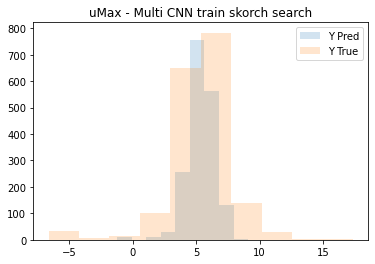

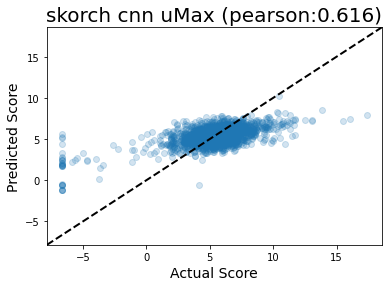

task:lowO2_fast_growth


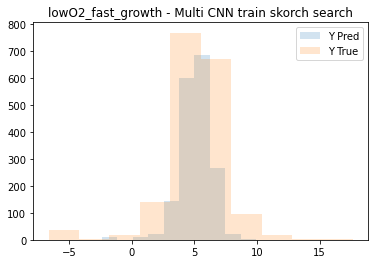

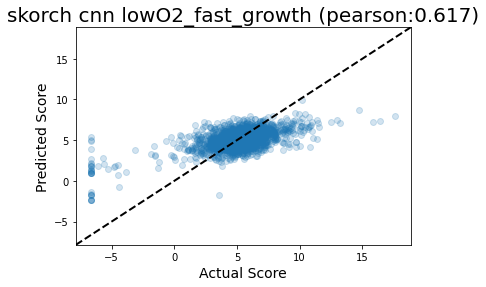

task:lowCH4


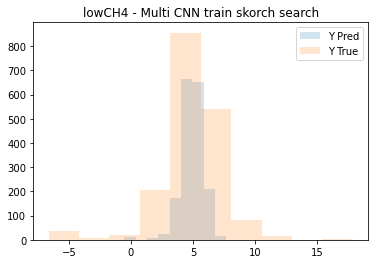

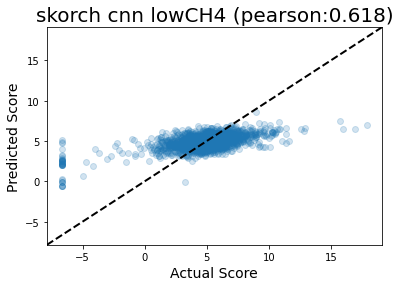

task:MeOH


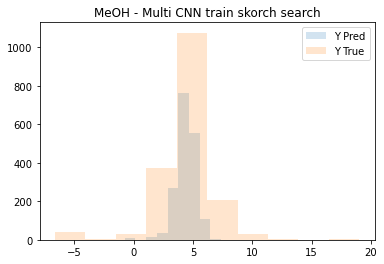

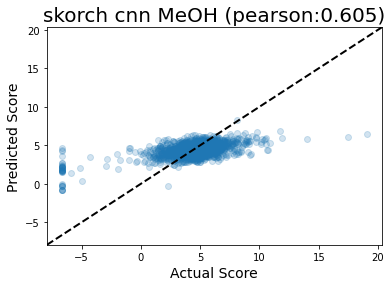

task:NoCu


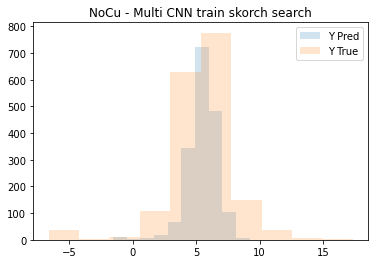

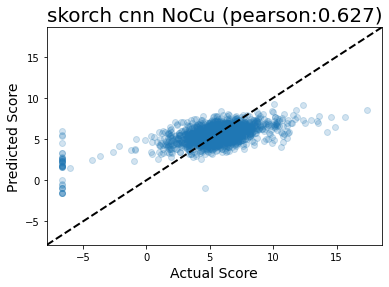

task:medCu


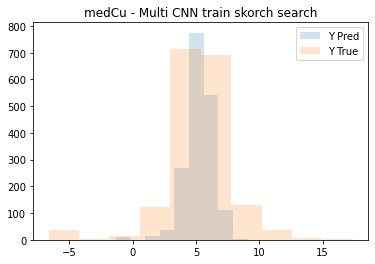

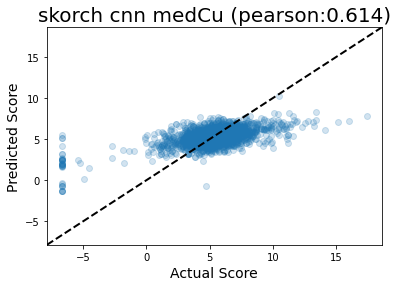

task:highCu


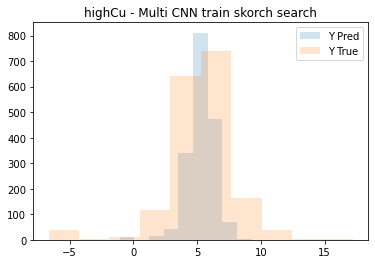

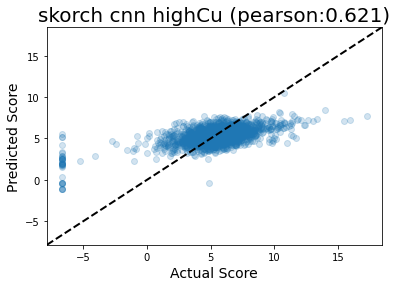

task:lowCu


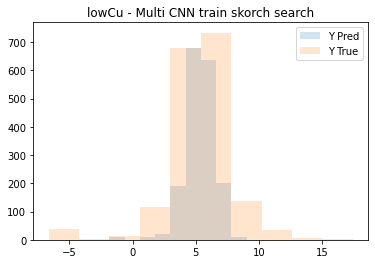

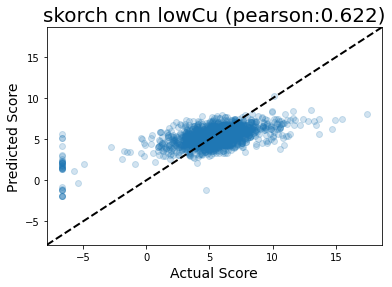

task:highO2_slow_growth


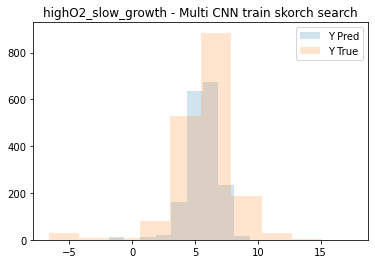

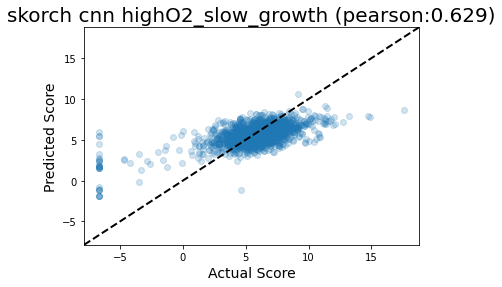

task:NO3_lowO2_slow_growth


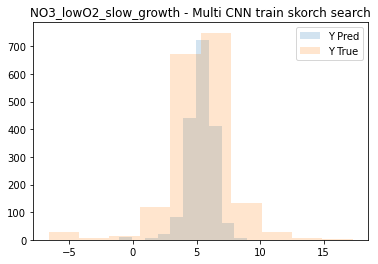

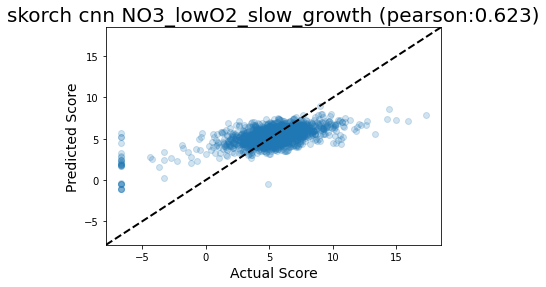

task:WithLanthanum


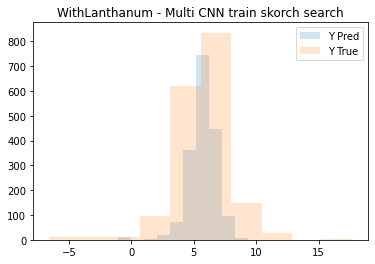

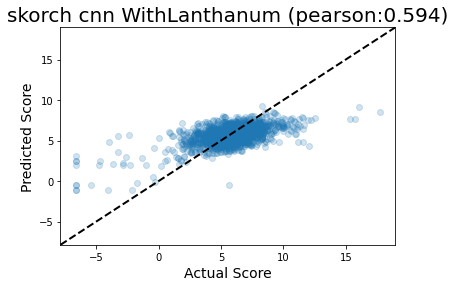

task:NoLanthanum


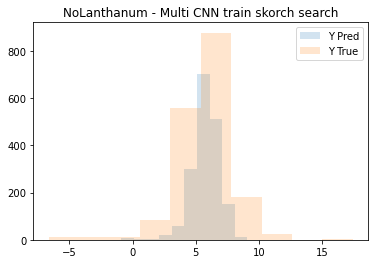

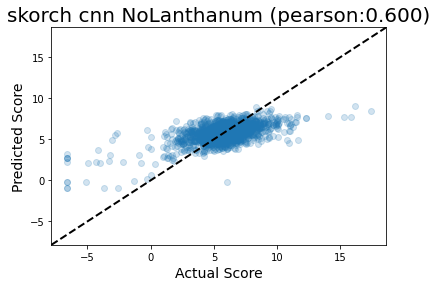

In [97]:
check_mt_pred_results(ym, ymsearch_pred_train,"Multi CNN train skorch search")

In [99]:
Xmtest,ymtest = make_multi_skorch_dfs(log_test_df, seq_col='upstream_region')
print("X m test:",Xmtest.shape)
print("y m test:",ymtest.shape)

X m test: torch.Size([441, 300, 4])
y m test: torch.Size([441, 12])


In [100]:
ymsearch_pred_test = m_search.best_estimator_.predict(Xmtest)

task:uMax


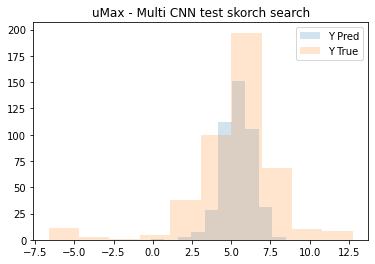

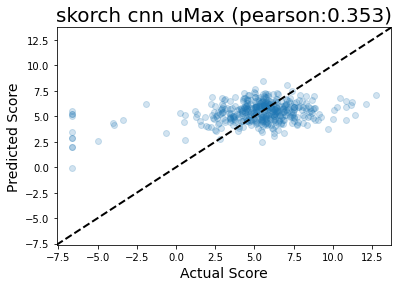

task:lowO2_fast_growth


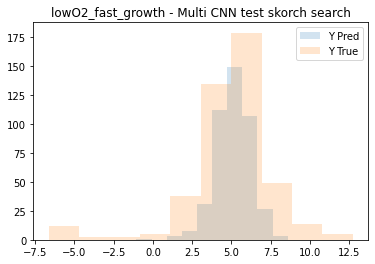

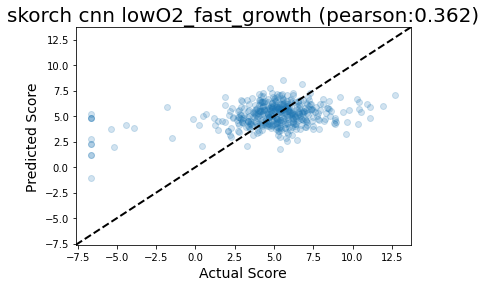

task:lowCH4


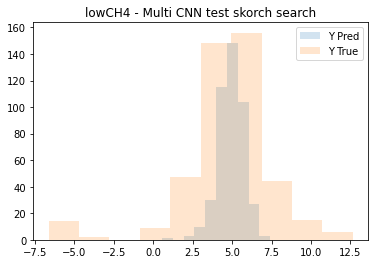

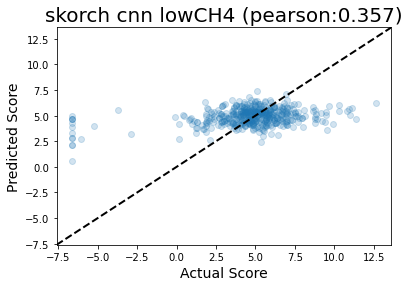

task:MeOH


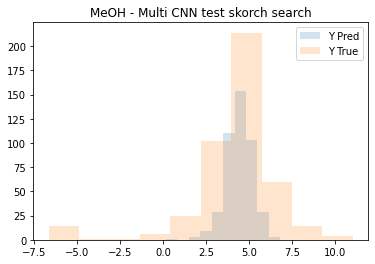

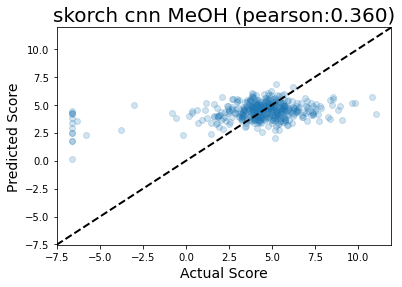

task:NoCu


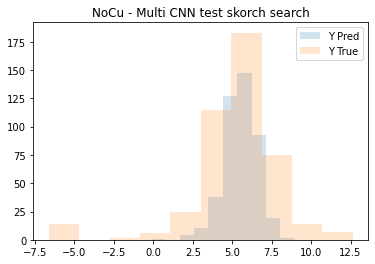

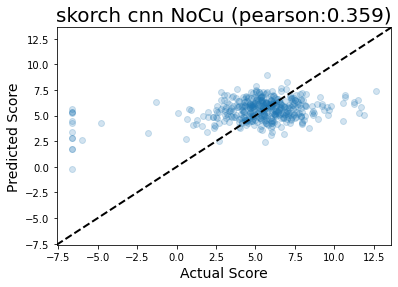

task:medCu


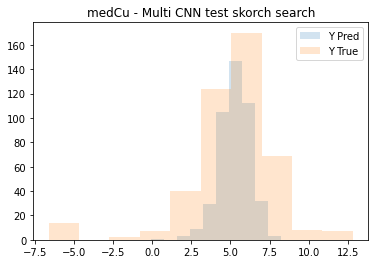

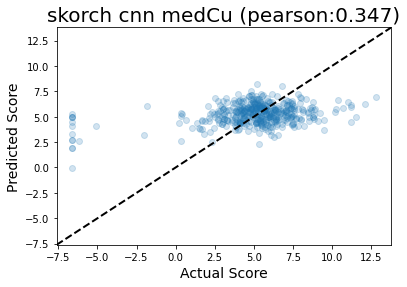

task:highCu


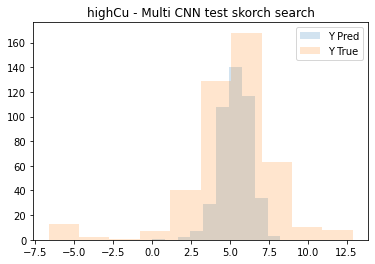

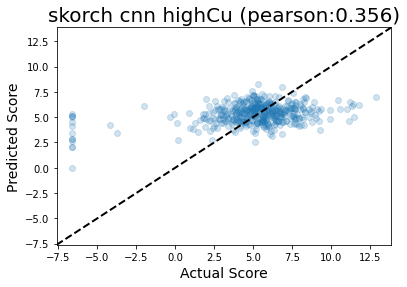

task:lowCu


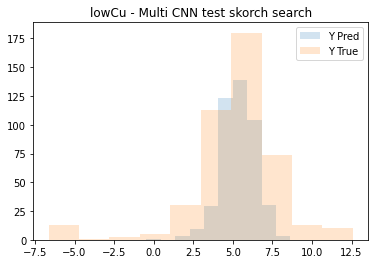

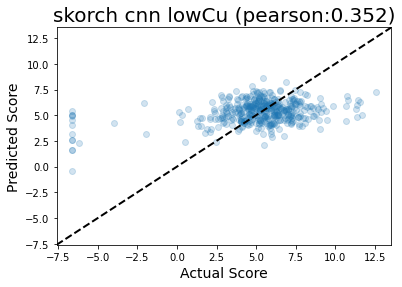

task:highO2_slow_growth


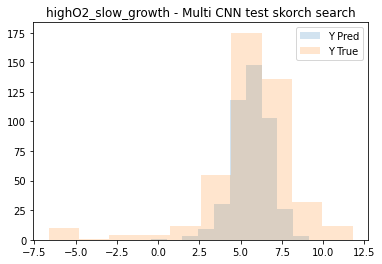

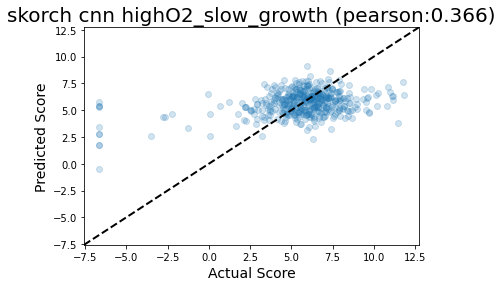

task:NO3_lowO2_slow_growth


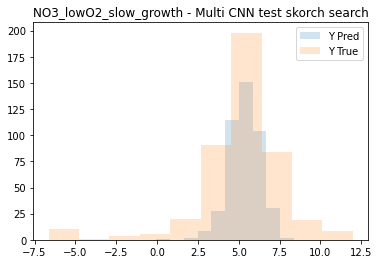

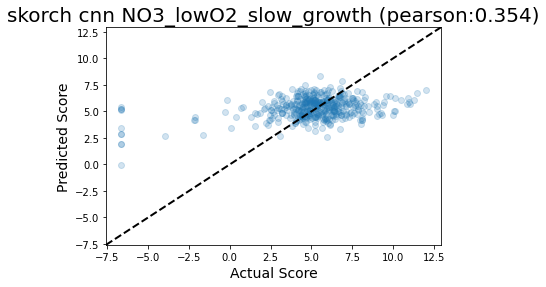

task:WithLanthanum


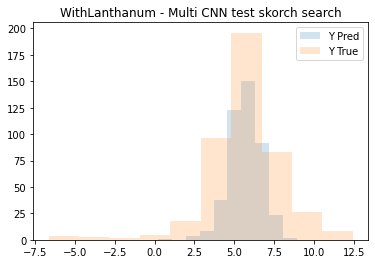

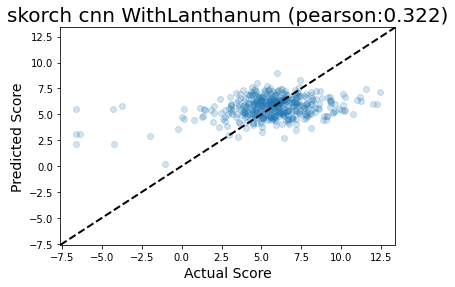

task:NoLanthanum


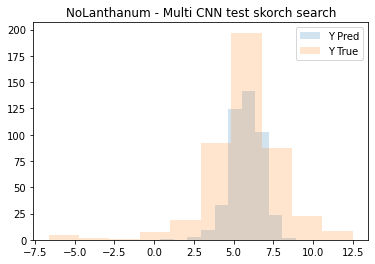

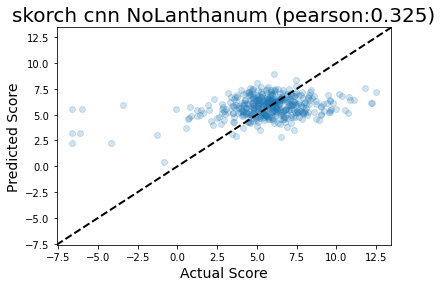

In [101]:
check_mt_pred_results(ymtest, ymsearch_pred_test,"Multi CNN test skorch search")

In [102]:
mres_df.to_csv("multi_skorch_search_res_df.tsv",sep='\t', index=False)

In [8]:
test = pd.read_csv('multi_skorch_search_res_df.tsv',sep='\t')

In [9]:
test

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__num_filters,param_module__num_fc_nodes1,param_module__kernel_size,param_lr,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,opt_name
0,59.104487,0.685902,0.010845,0.001480,<class 'torch.optim.adam.Adam'>,16,10,32,0.00050,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-18.853952,-23.230394,-21.319815,-22.497879,-22.695402,-21.719489,1.562829,376,Adam
1,59.337368,2.253942,0.013646,0.002544,<class 'torch.optim.adam.Adam'>,64,50,16,0.00001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-5.946605,-5.320988,-7.279854,-5.753273,-8.405795,-6.541303,1.138913,123,Adam
2,62.643943,0.526686,0.014259,0.001357,<class 'torch.optim.adam.Adam'>,128,25,8,0.00010,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-17.657255,-21.508598,-20.662313,-21.507624,-22.012827,-20.669724,1.567465,355,Adam
3,57.970003,2.599069,0.011775,0.001051,<class 'torch.optim.adam.Adam'>,32,100,4,0.00010,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-18.295582,-19.663145,-19.988087,-18.631847,-20.820629,-19.479858,0.917735,340,Adam
4,40.366428,4.052095,0.012646,0.002078,<class 'torch.optim.sgd.SGD'>,32,25,4,0.00010,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-6.104009,-4.963671,-7.213747,-5.209205,-7.599255,-6.217977,1.049131,47,SGD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,54.819225,1.421057,0.013606,0.001281,<class 'torch.optim.rmsprop.RMSprop'>,128,10,8,0.00050,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-19.959888,-24.360632,-22.448183,-22.932302,-22.832281,-22.506657,1.429257,413,RMSprop
496,56.441145,0.595706,0.011243,0.000335,<class 'torch.optim.adam.Adam'>,16,100,4,0.00001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-6.131781,-4.998219,-6.853837,-5.415829,-7.572523,-6.194438,0.935417,31,Adam
497,43.649200,5.467568,0.015853,0.005174,<class 'torch.optim.sgd.SGD'>,32,10,8,0.00001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-7.034853,-9.071085,-13.716123,-13.504837,-8.366921,-10.338764,2.751057,248,SGD
498,77.238276,5.039324,0.017579,0.003002,<class 'torch.optim.adam.Adam'>,128,100,16,0.00050,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-21.778761,-26.515709,-24.488634,-25.060144,-24.044800,-24.377610,1.543660,460,Adam


In [10]:
sm_mres_df = test[["rank_test_score","mean_test_score","param_module__num_filters","param_module__kernel_size","param_lr","param_module__num_fc_nodes1","opt_name"]]

In [11]:
alt.Chart(sm_mres_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N"
    
).interactive()

alt.Chart(...)

In [12]:
alt.Chart(sm_mres_df).mark_point().encode(
    x='param_module__num_filters:O',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
    column='opt_name:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N",
    tooltip=["param_module__num_filters:N","param_module__kernel_size:N","param_lr:N","param_module__num_fc_nodes1:N"]
    
).interactive()

alt.Chart(...)